In [1]:
from google.cloud import bigquery
import pandas as pd
import os
import time
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 150
import seaborn as sns

pd.options.display.max_columns = 50
pd.options.display.max_rows = 100
pd.options.display.min_rows = 20

In [2]:
os.environ['GOOGLE_APPLICATION+CREDENTIALS'] = '/Users/nrabbani/.config/gcloud/application_default_credentials.json'
os.environ['GCLOUD_PROJECT'] = 'mining-clinical-decisions'
%load_ext google.cloud.bigquery

client=bigquery.Client()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For mor

In [2]:
lradt = pd.read_pickle('data/lradt_20210927.pkl')

In [3]:
# Get rid of labs ordered on the last day, due to issues with the timing right at the edge. There are multiple
# labs that have the order time and result time of 2021-10-31 00:00:00 and that is messing up the repetition 
print('Before pruning last day of labs:\t', len(lradt))
lradt = lradt.loc[lradt.result_time < lradt.result_time.max()]
print('After pruning last day of labs:\t\t', len(lradt))

Before pruning last day of labs:	 4996609
After pruning last day of labs:		 4935345


In [4]:
lradt['njr_labname'] = lradt['group_lab_name']

In [5]:
cbc =  ['CBC with Differential', 'CBC with Diff', 'CBC', 'CBC with Diff and Slide Review']
poct_urine = ['POCT Urine Dipstick (10)', 'POCT Urine Dipstick (9)']
poct_glucose = ['Glucose By Meter', 'Glucose PCX Meter']
lradt.loc[lradt.njr_labname.isin(cbc), 'njr_labname'] = 'CBC'
lradt.loc[lradt.njr_labname.isin(poct_urine), 'njr_labname'] = 'POCT Urine'
lradt.loc[lradt.njr_labname.isin(poct_glucose), 'njr_labname'] = 'POCT Glucose'

In [6]:
pd.DataFrame(lradt.njr_labname.value_counts()).head(30)

,njr_labname
CBC,1121833
Chem 10,582287
"Metabolic Panel, Comprehensive",401446
Renal Function Panel,315484
POCT Urine,234366
Urinalysis Macroscopic Only,209979
Manual Differential/Slide Review,188767
Urinalysis With Microscopic,126466
POCT Glucose,100155
Red Blood Cells,96574


In [7]:
labcounts = lradt.groupby(by='njr_labname').agg({'order_id_coded': 'nunique', 'pat_enc_csn_id_coded': 'nunique', 'anon_id': 'nunique'}).rename(columns={'order_id_coded': 'norders', 'pat_enc_csn_id_coded': 'nenc', 'anon_id': 'npat'}).sort_values('norders', ascending=False).head(30)

In [8]:
labcounts.head(30)

,norders,nenc,npat
njr_labname,,,
CBC,70271,16811,8179
Chem 10,47187,10151,4598
POCT Glucose,47098,3565,2253
"Magnesium, Ser/Plas",41927,8672,4639
Renal Function Panel,25509,5475,3068
POCT Urine,23519,2904,1353
"Metabolic Panel, Comprehensive",23074,8163,4820
"Phosphorus, Ser/Plas",20888,5302,3330
Urinalysis Macroscopic Only,19687,2308,1004


In [9]:
labcounts['per_enc'] = labcounts.norders/labcounts.nenc
labcounts.sort_values(by='per_enc', ascending=False).head(30)

,norders,nenc,npat,per_enc
njr_labname,,,,
POCT Glucose,47098,3565,2253,13.211220
Urinalysis Macroscopic Only,19687,2308,1004,8.529896
"Uric Acid, Ser/Plas",9360,1105,916,8.470588
POCT Urine,23519,2904,1353,8.098829
"LDH Total, Ser/Plas",9191,1453,1116,6.325533
Platelets,8579,1525,891,5.625574
"Tacrolimus Level, FK506",13054,2552,801,5.115204
"Magnesium, Ser/Plas",41927,8672,4639,4.834756
"Triglyceride, Ser/Plas",7402,1565,1035,4.729712


In [10]:
enclabcounts = lradt.groupby(by=['pat_enc_csn_id_coded', 'njr_labname']).agg({'order_id_coded': 'nunique'}).rename(columns={'order_id_coded': 'norders'}).sort_values('pat_enc_csn_id_coded', ascending=False)

In [11]:
enclabcounts = enclabcounts.reset_index()

In [12]:
len(enclabcounts.pat_enc_csn_id_coded.unique())

25693

In [13]:
enclabcounts.loc[enclabcounts.norders>1].groupby('njr_labname').agg({'pat_enc_csn_id_coded' : 'nunique', 'norders' : 'mean'}).sort_values('pat_enc_csn_id_coded', ascending=False).head(15)

,pat_enc_csn_id_coded,norders
njr_labname,,
CBC,8461,7.318402
Chem 10,6999,6.291613
"Magnesium, Ser/Plas",4714,8.054518
Renal Function Panel,3546,6.649746
"Metabolic Panel, Comprehensive",3107,5.799163
POCT Urine,2816,8.320668
Manual Differential/Slide Review,2346,7.192668
POCT Glucose,2315,19.804752
ABO Rh Typing,2314,5.295592


In [24]:
tempdf2 = enclabcounts.groupby('njr_labname').agg({'pat_enc_csn_id_coded' : 'nunique', 'norders' : 'sum'}).sort_values('norders', ascending=False)
tempdf2.head(30)

,pat_enc_csn_id_coded,norders
njr_labname,,
CBC,16811,70271
Chem 10,10151,47187
POCT Glucose,3565,47098
"Magnesium, Ser/Plas",8672,41927
Renal Function Panel,5475,25509
POCT Urine,2904,23519
"Metabolic Panel, Comprehensive",8163,23074
"Phosphorus, Ser/Plas",5302,20888
Urinalysis Macroscopic Only,2308,19687


In [26]:
tempdf2['perenc'] = tempdf2.norders / tempdf2.pat_enc_csn_id_coded
tempdf2 = tempdf2.loc[tempdf2.pat_enc_csn_id_coded > 500].sort_values('perenc', ascending=False)
# tempdf2 = tempdf2.sort_values('perenc', ascending=False)
tempdf2.head(30)

,pat_enc_csn_id_coded,norders,perenc
njr_labname,,,
POCT Glucose,3565,47098,13.211220
Urinalysis Macroscopic Only,2308,19687,8.529896
"Uric Acid, Ser/Plas",1105,9360,8.470588
POCT Urine,2904,23519,8.098829
"LDH Total, Ser/Plas",1453,9191,6.325533
"Calcium Ionized, Whole Blood",702,4264,6.074074
"Sodium, Ser/Plas",536,3107,5.796642
Platelets,1525,8579,5.625574
"Tacrolimus Level, FK506",2552,13054,5.115204


In [55]:
labnames = tempdf2.index.to_list()[0:15]
print(labnames)

['POCT Glucose', 'Urinalysis Macroscopic Only', 'Uric Acid, Ser/Plas', 'POCT Urine', 'LDH Total, Ser/Plas', 'Platelets', 'Tacrolimus Level, FK506', 'Magnesium, Ser/Plas', 'Triglyceride, Ser/Plas', 'Renal Function Panel', 'Chem 10', 'Methotrexate Level', 'Manual Differential/Slide Review', 'CBC', 'Phosphorus, Ser/Plas']


In [56]:
lradt_orders = lradt.loc[lradt.njr_labname.isin(labnames)].groupby('order_id_coded').first()

In [57]:
len(lradt_orders)

367082

In [58]:
ordersdf = lradt_orders[['anon_id', 'pat_enc_csn_id_coded', 'njr_labname', 'order_time', 'result_time']].sort_values(['pat_enc_csn_id_coded', 'njr_labname', 'result_time', 'order_time'])
ordersdf.head(5)

,anon_id,pat_enc_csn_id_coded,njr_labname,order_time,result_time
order_id_coded,,,,,
702121786,JC626416,308895713,CBC,2014-06-16 22:20:00,2014-06-16 22:41:00
702121788,JC626416,308895713,"Uric Acid, Ser/Plas",2014-06-16 22:20:00,2014-06-16 22:53:00
701122666,JC608450,308903549,CBC,2014-05-25 21:05:00,2014-05-26 07:24:00
701239393,JC639827,308903923,CBC,2014-06-02 21:05:00,2014-06-03 08:06:00
701504059,JC984330,308904689,CBC,2014-06-30 21:05:00,2014-07-01 07:51:00


In [59]:
ordersdf.shift(1).head(5)

,anon_id,pat_enc_csn_id_coded,njr_labname,order_time,result_time
order_id_coded,,,,,
702121786,NaN,NaN,NaN,NaT,NaT
702121788,JC626416,308895713,CBC,2014-06-16 22:20:00,2014-06-16 22:41:00
701122666,JC626416,308895713,"Uric Acid, Ser/Plas",2014-06-16 22:20:00,2014-06-16 22:53:00
701239393,JC608450,308903549,CBC,2014-05-25 21:05:00,2014-05-26 07:24:00
701504059,JC639827,308903923,CBC,2014-06-02 21:05:00,2014-06-03 08:06:00


In [60]:
ordersdf_shift = ordersdf.shift(1)
ordersdf['dif'] = pd.NaT
ordersdf['dif'] = ordersdf.order_time - ordersdf_shift.order_time

In [61]:
newlabidx = (ordersdf.njr_labname != ordersdf_shift.njr_labname) | (ordersdf.pat_enc_csn_id_coded != ordersdf_shift.pat_enc_csn_id_coded)

In [62]:
ordersdf.loc[newlabidx, 'dif'] = pd.NaT

In [63]:
ordersdf.head(30)

,anon_id,pat_enc_csn_id_coded,njr_labname,order_time,result_time,dif
order_id_coded,,,,,,
702121786,JC626416,308895713,CBC,2014-06-16 22:20:00,2014-06-16 22:41:00,NaT
702121788,JC626416,308895713,"Uric Acid, Ser/Plas",2014-06-16 22:20:00,2014-06-16 22:53:00,NaT
701122666,JC608450,308903549,CBC,2014-05-25 21:05:00,2014-05-26 07:24:00,NaT
701239393,JC639827,308903923,CBC,2014-06-02 21:05:00,2014-06-03 08:06:00,NaT
701504059,JC984330,308904689,CBC,2014-06-30 21:05:00,2014-07-01 07:51:00,NaT
701287760,JC1142284,308905542,CBC,2014-05-02 13:35:00,2014-05-02 17:42:00,NaT
701390874,JC1142284,308905542,CBC,2014-05-03 21:05:00,2014-05-04 08:24:00,1 days 07:30:00
701504067,JC1142284,308905542,CBC,2014-05-09 12:28:00,2014-05-09 13:37:00,5 days 15:23:00
701287759,JC1142284,308905542,Chem 10,2014-05-02 13:35:00,2014-05-02 18:04:00,NaT


In [64]:
repeat_orders = ordersdf.loc[ordersdf.dif.notnull()]
repeat_orders.head(10)

,anon_id,pat_enc_csn_id_coded,njr_labname,order_time,result_time,dif
order_id_coded,,,,,,
701390874,JC1142284,308905542,CBC,2014-05-03 21:05:00,2014-05-04 08:24:00,1 days 07:30:00
701504067,JC1142284,308905542,CBC,2014-05-09 12:28:00,2014-05-09 13:37:00,5 days 15:23:00
701457513,JC1142284,308905542,Chem 10,2014-05-08 21:05:00,2014-05-09 05:49:00,6 days 07:30:00
701457516,JC1142284,308905542,Chem 10,2014-05-09 05:55:00,2014-05-09 07:26:00,0 days 08:50:00
701504073,JC1142284,308905542,Chem 10,2014-05-09 21:05:00,2014-05-10 05:28:00,0 days 15:10:00
701504087,JC1142284,308905542,Chem 10,2014-05-10 21:05:00,2014-05-11 06:32:00,1 days 00:00:00
701504106,JC1142284,308905542,Chem 10,2014-05-11 21:05:00,2014-05-12 06:00:00,1 days 00:00:00
701580858,JC1142284,308905542,Chem 10,2014-05-12 21:05:00,2014-05-13 03:48:00,1 days 00:00:00
703408214,JC605249,308913369,CBC,2014-09-10 21:05:00,2014-09-11 07:45:00,41 days 13:07:00


In [65]:
time_quant = [pd.Timedelta('24H'), pd.Timedelta('3D'), pd.Timedelta('1W')]

In [66]:
labdtq_idx = ['<24h', '[24h, 3d)', '[3d, 7d)', '>=7d']
labdtq = pd.DataFrame(index=labdtq_idx)
for lab in labnames:
    print('Lab: ', lab)
    dtimes = ordersdf.loc[ordersdf.njr_labname==lab].dif
    p_enc = ordersdf.loc[ordersdf.njr_labname==lab, 'pat_enc_csn_id_coded'].nunique()
    dtq = []
    dtq.append(sum(dtimes < pd.Timedelta('24H')))
    dtq.append(sum( (dtimes < pd.Timedelta('3D')) & (dtimes >= pd.Timedelta('24H')) ))
    dtq.append(sum( (dtimes < pd.Timedelta('7D')) & (dtimes >= pd.Timedelta('3D')) ))
    dtq.append(sum((dtimes >= pd.Timedelta('7D')) | (dtimes.isnull()) ))
    dtq
    print('[0, 24h):\t', dtq[0])
    print('[24h, 3d)]:\t', dtq[1])
    print('[3d, 7d)]:\t', dtq[2])
    print('[7d, inf)]:\t', dtq[3])
    labdtq[lab] = np.cumsum(dtq)/p_enc*1000

Lab:  POCT Glucose
[0, 24h):	 42306
[24h, 3d)]:	 643
[3d, 7d)]:	 266
[7d, inf)]:	 3883
Lab:  Urinalysis Macroscopic Only
[0, 24h):	 11302
[24h, 3d)]:	 5814
[3d, 7d)]:	 171
[7d, inf)]:	 2400
Lab:  Uric Acid, Ser/Plas
[0, 24h):	 6380
[24h, 3d)]:	 1624
[3d, 7d)]:	 131
[7d, inf)]:	 1225
Lab:  POCT Urine
[0, 24h):	 6944
[24h, 3d)]:	 13557
[3d, 7d)]:	 89
[7d, inf)]:	 2929
Lab:  LDH Total, Ser/Plas
[0, 24h):	 4896
[24h, 3d)]:	 2246
[3d, 7d)]:	 400
[7d, inf)]:	 1649
Lab:  Platelets
[0, 24h):	 2902
[24h, 3d)]:	 2429
[3d, 7d)]:	 1389
[7d, inf)]:	 1859
Lab:  Tacrolimus Level, FK506
[0, 24h):	 1704
[24h, 3d)]:	 8213
[3d, 7d)]:	 471
[7d, inf)]:	 2666
Lab:  Magnesium, Ser/Plas
[0, 24h):	 6651
[24h, 3d)]:	 23022
[3d, 7d)]:	 2532
[7d, inf)]:	 9722
Lab:  Triglyceride, Ser/Plas
[0, 24h):	 577
[24h, 3d)]:	 2575
[3d, 7d)]:	 2207
[7d, inf)]:	 2043
Lab:  Renal Function Panel
[0, 24h):	 6123
[24h, 3d)]:	 12153
[3d, 7d)]:	 1220
[7d, inf)]:	 6013
Lab:  Chem 10
[0, 24h):	 12799
[24h, 3d)]:	 21277
[3d, 7d)]:	 21

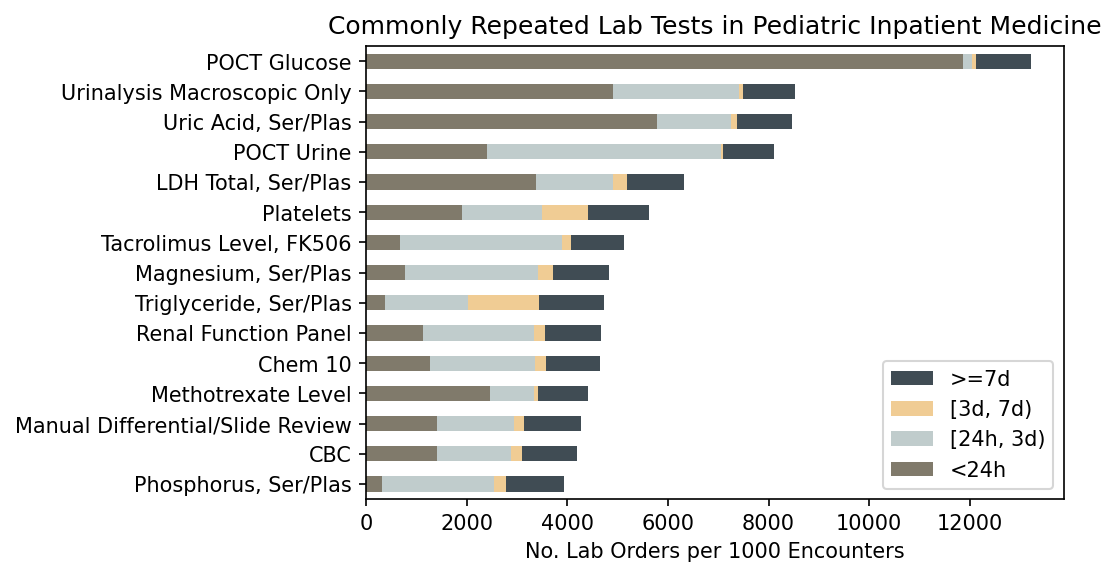

In [67]:
ax1 = labdtq.iloc[3].plot.barh(color='#404c54');
labdtq.iloc[2].plot.barh(ax=ax1, color='#f0cc94');
labdtq.iloc[1].plot.barh(ax=ax1, color='#c0cccc');
labdtq.iloc[0].plot.barh(ax=ax1, color='#807A6B');
ax1.legend();
ax1.invert_yaxis();
ax1.set_title('Commonly Repeated Lab Tests in Pediatric Inpatient Medicine');
ax1.set_xlabel('No. Lab Orders per 1000 Encounters');

In [34]:
lradt.base_name.value_counts().head(30)

PERFLAB    309773
GLU        118516
NA         114790
K          113472
CL         110678
CR         108079
BUN        106437
CA         106258
CO2        105811
AG         105797
PHOS        94803
EGFR        93903
MG          90315
HCT         77788
HGB         77616
WBC         70452
PLT         70340
RBC         70176
MCV         70165
RDW         70089
MCHC        70078
MCH         70074
PCCOM       59757
ALB         59307
LYM         56287
NEUT        54897
LYMAB       54701
MONO        54355
MONOAB      54059
NITRITE     52027
Name: base_name, dtype: int64

In [308]:
def windowedLabCounts(LABNAME, LOWER, UPPER, plot_flag = False):
    lrdf = lradt.loc[(lradt.base_name==LABNAME) & (lradt.ord_num_value < UPPER) & (lradt.ord_num_value > LOWER)].sort_values(by=['pat_enc_csn_id_coded', 'result_time']).reset_index()
    lrdf['result'] = 'N'
    lrdf.loc[(lrdf.result_in_range_yn!='Y') & ((lrdf.result_flag=='High') | (lrdf.result_flag=='High Panic')), 'result'] = 'H'
    lrdf.loc[(lrdf.result_in_range_yn!='Y') & ((lrdf.result_flag=='Low') | (lrdf.result_flag=='Low Panic')), 'result'] = 'L'
    lrdf['normal'] = (lrdf.result=='N')
    print('LAB:', LABNAME)
    print(lrdf.normal.value_counts())

    lrdf['preceding']=0
    for enc in lrdf.pat_enc_csn_id_coded.unique():
        enc_idx = (lrdf.pat_enc_csn_id_coded==enc)
        df = lrdf.loc[enc_idx, ['result_time', 'normal']]
        rownum = 0
        for (idx, row) in df.iterrows():
            if rownum>0:
                rtime = row.result_time
                dfslice = df.loc[(df.result_time <= rtime) & (df.result_time > rtime - pd.Timedelta('7D'))]
                if dfslice.shift().loc[idx, 'normal']==True:
                    y = dfslice.shift().normal
                    prec = y * (y.groupby((y != y.shift()).cumsum()).cumcount() + 1)
                    lrdf.loc[idx, 'preceding'] = prec.values[-1]
            rownum = rownum + 1
    
    if plot_flag:
        dfstab = lrdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:7]
        dfstab['prop'] = dfstab['normal']['sum']/dfstab['normal']['count'].astype('float')
        ax = dfstab.prop.plt()
        ax.set_xlabel('Consecutive Normal Results in Past 7 Days Preceding Lab');
        ax.set_ylabel('Proportion Normal Results');
        ax.set_title('Stability for Common Inpatient Laboratory Studies');
        ax.set_ylim(0, 1.0);
    
    return lrdf

In [258]:
nadf = windowedLabCounts('NA', 0, 200);
kdf = windowedLabCounts('K', 0, 8);
mgdf = windowedLabCounts('MG', 0, 10);
phosdf = windowedLabCounts('PHOS', 0, 50);
crdf = windowedLabCounts('CR', 0, 20);
wbcdf = windowedLabCounts('WBC', 0, 100000);
hgbdf = windowedLabCounts('HGB', 0, 30);
pltdf = windowedLabCounts('PLT', 0, 500000)

LAB: NA
True     90397
False    24298
Name: normal, dtype: int64
LAB: K
True     91093
False    22115
Name: normal, dtype: int64
LAB: MG
True     61984
False    28272
Name: normal, dtype: int64
LAB: PHOS
True     63707
False    31024
Name: normal, dtype: int64
LAB: CR
True     78232
False    29325
Name: normal, dtype: int64
LAB: WBC
False    41838
True     26917
Name: normal, dtype: int64
LAB: HGB
False    64875
True     12583
Name: normal, dtype: int64


In [311]:
nastab = nadf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:7]
kstab = kdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:7]
mgstab = mgdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:7]
phosstab = phosdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:7]
crstab = crdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:7]
wbcstab = wbcdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:7]
hgbstab = hgbdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:7]
pltstab = pltdf.groupby('preceding').agg({'normal' : ['sum', 'count']})[0:7]

In [413]:
labstab = pd.DataFrame()
labstab['Sodium'] = nastab['normal']['sum']/nastab['normal']['count'].astype('float')
labstab['Potassium'] = kstab['normal']['sum']/kstab['normal']['count'].astype('float')
labstab['Creatinine'] = crstab['normal']['sum']/crstab['normal']['count'].astype('float')
labstab['Magnesium']  = mgstab['normal']['sum']/mgstab['normal']['count'].astype('float')
labstab['Phosphorus'] = phosstab['normal']['sum']/phosstab['normal']['count'].astype('float')
labstab['White Cells'] = wbcstab['normal']['sum']/wbcstab['normal']['count'].astype('float')
labstab['Hemoglobin'] = hgbstab['normal']['sum']/hgbstab['normal']['count'].astype('float')
labstab['Platelets'] = pltstab['normal']['sum']/pltstab['normal']['count'].astype('float')

In [414]:
labstab.head(5)

,Sodium,Potassium,Creatinine,Magnesium,Phosphorus,White Cells,Hemoglobin,Platelets
preceding,,,,,,,,
0,0.618692,0.635123,0.430926,0.494435,0.496371,0.270960,0.116253,0.249895
1,0.844057,0.853537,0.895200,0.769509,0.742317,0.759626,0.588298,0.834582
2,0.880234,0.893681,0.941019,0.840809,0.817151,0.814815,0.685606,0.859774
3,0.900209,0.917751,0.958936,0.877298,0.847630,0.832061,0.719764,0.880303
4,0.906126,0.918838,0.971186,0.881874,0.859201,0.831041,0.758621,0.891269


In [415]:
def plotLabStab(df, ndays, ax = None, subset=False, labs=['']):
    df = df[0:ndays+1]
    if subset:
        df = df[labs]
    sns.set_style("white");
    if ax is None:
        ax = sns.lineplot(data = df, markers=True);
    else:
        sns.lineplot(data = df, markers=True, ax = ax);
    ax.set_xlabel('Consecutive Normal Results in Past 7 Days Preceding Lab');
    ax.set_xlim(-0.25, ndays+0.25)
    ax.set_xticks(np.arange(ndays+1))
    ax.set_ylabel('Proportion Normal Results');
    ax.set_title('Stability for Common Inpatient Laboratory Studies');
    ax.set_ylim(0, 1.0);
    return ax

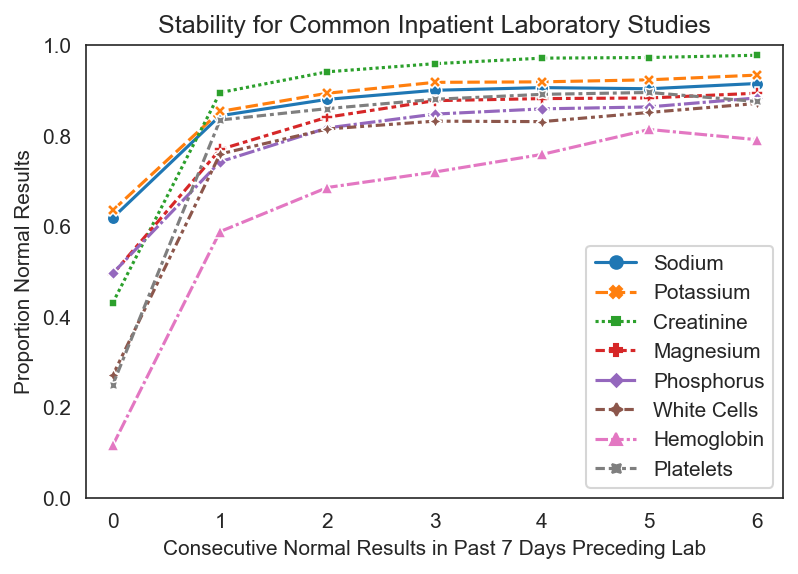

In [417]:
plotLabStab(labstab, 6);

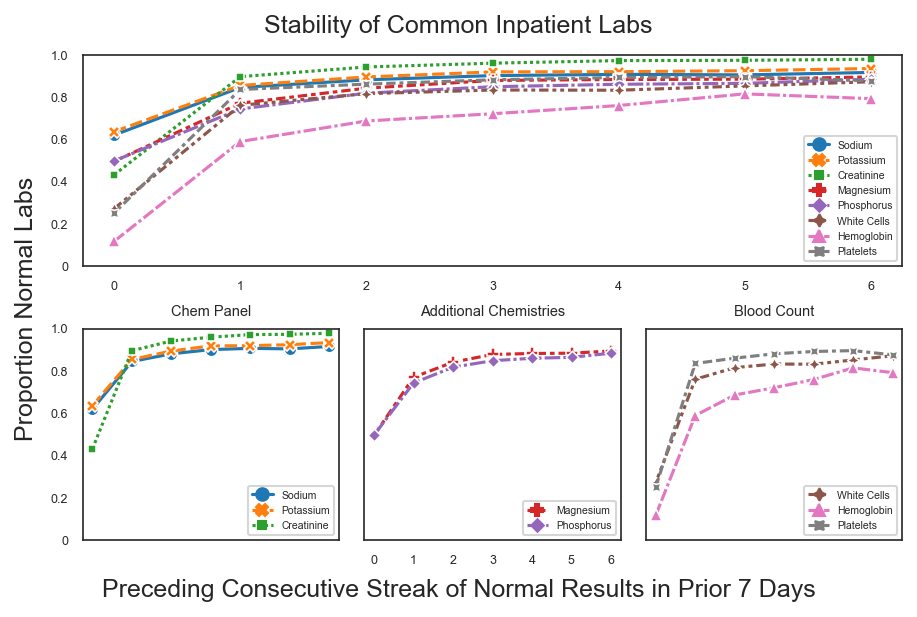

In [466]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(constrained_layout=True)
gs = GridSpec(2, 3, figure=fig)
axes = []
# create sub plots as grid
axes.append(fig.add_subplot(gs[0, :]))
axes.append(fig.add_subplot(gs[1, 0]))
axes.append(fig.add_subplot(gs[1, 1], sharey=axes[1]))
axes.append(fig.add_subplot(gs[1, 2], sharey=axes[1]))

chem1 = ['Sodium', 'Potassium', 'Creatinine']
chem2 = ['Magnesium', 'Phosphorus']
cbc = ['White Cells', 'Hemoglobin', 'Platelets']
cmap = sns.color_palette()

STREAK = 6
sns.set_style("white");
dash_list = sns._core.unique_dashes(8);
marker_list = sns._core.unique_markers(8)
sns.lineplot(data=labstab[0:STREAK+1], ax = axes[0],
             palette = cmap[0:8], dashes=dash_list, markers=marker_list);
sns.lineplot(data=labstab[chem1][0:STREAK+1], ax=axes[1],
             palette = cmap[0:3], dashes=dash_list[0:3], markers=marker_list[0:3])
sns.lineplot(data=labstab[chem2][0:STREAK+1], ax=axes[2], 
             palette = cmap[3:5], dashes=dash_list[3:5], markers=marker_list[3:5])
sns.lineplot(data=labstab[cbc][0:STREAK+1], ax=axes[3], 
             palette = cmap[5:8], dashes=dash_list[5:8], markers=marker_list[5:8])


# plotLabStab(labstab, 6, ax=axes[0]);
# plotLabStab(labstab, 6, ax = axes[1], subset = True, labs = ['Sodium', 'Potassium', 'Creatinine']);
# plotLabStab(labstab, 6, ax = axes[2], subset = True, labs = ['Magnesium', 'Phosphorus']);
# plotLabStab(labstab, 6, ax = axes[3], subset = True, labs = ['White Cells', 'Hemoglobin', 'Platelets']);

for ax in axes:
    ax.set_xlim(-0.25, STREAK+0.25);
    ax.set_ylim(0, 1);
    ax.set_xticks(np.arange(STREAK+1));
    ax.set_xticklabels(labels=np.arange(STREAK+1), fontsize=6);
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(labels=[0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=6);
    ax.set_ylabel('');
    ax.set_xlabel('');
    ax.set_title('');
    ax.legend(fontsize=5, loc=4);
    
#axes[0].set_title('All')
axes[1].set_title('Chem Panel', fontsize=7);
axes[2].set_title('Additional Chemistries', fontsize=7);
axes[3].set_title('Blood Count', fontsize=7);
plt.setp(axes[2].get_yticklabels(), visible=False)
plt.setp(axes[3].get_yticklabels(), visible=False)
plt.setp(axes[1].get_xticklabels(), visible=False)
plt.setp(axes[3].get_xticklabels(), visible=False)
axes[0].xaxis.labelpad = 10000;

fig.supylabel('Proportion Normal Labs');
fig.supxlabel('Preceding Consecutive Streak of Normal Results in Prior 7 Days');
fig.suptitle('Stability of Common Inpatient Labs');

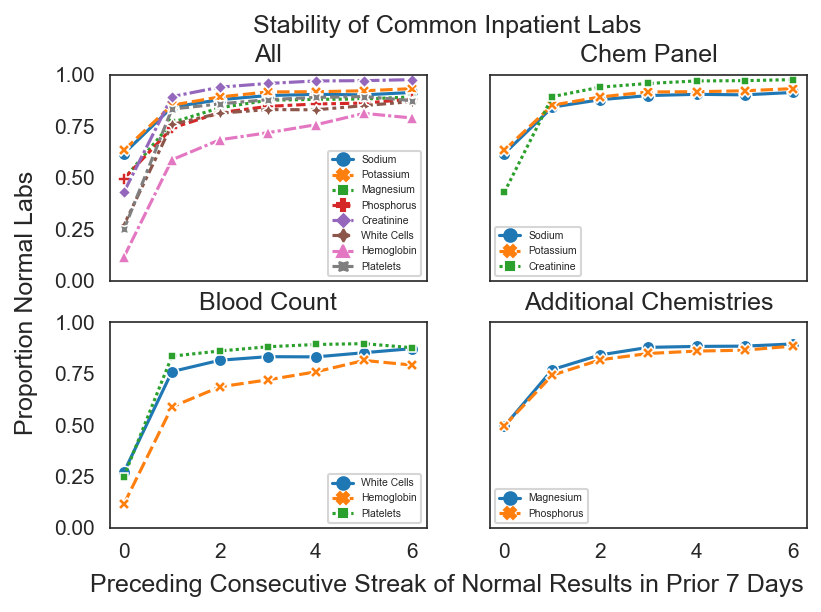

In [360]:
fig, axes = plt.subplots(2, 2, sharey = True, sharex = True);
plotLabStab(labstab, 6, ax=axes[0][0]);
plotLabStab(labstab, 6, ax = axes[0][1], subset = True, labs = ['Sodium', 'Potassium', 'Creatinine']);
plotLabStab(labstab, 6, ax = axes[1][0], subset = True, labs = ['White Cells', 'Hemoglobin', 'Platelets']);
plotLabStab(labstab, 6, ax = axes[1][1], subset = True, labs = ['Magnesium', 'Phosphorus']);

for ax in axes.reshape(-1):
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend(fontsize=5)
axes[0][0].set_title('All')
axes[0][1].set_title('Chem Panel')
axes[1][0].set_title('Blood Count')
axes[1][1].set_title('Additional Chemistries')
fig.supylabel('Proportion Normal Labs');
fig.supxlabel('Preceding Consecutive Streak of Normal Results in Prior 7 Days');
fig.suptitle('Stability of Common Inpatient Labs');

In [472]:
lradt.loc[lradt.group_lab_name=='Blood Gases, Arterial'].pat_enc_csn_id_coded.value_counts()

316994052    288
316387272    270
311721758    255
311868608    255
319244154    252
314442120    238
313877087    238
311954171    238
321867423    228
311832770    221
            ... 
314083964     17
312066069     17
314790432     17
315719411     17
312916730     17
313870466     17
313605336     17
314652835     17
312093784     17
314079147     17
Name: pat_enc_csn_id_coded, Length: 679, dtype: int64

In [477]:
lradt.loc[(lradt.pat_enc_csn_id_coded==316994052) & (lradt.group_lab_name=='Blood Gases, Arterial')].sort_values(by='order_time').head(100)

,uid,anon_id,pat_enc_csn_id_coded,order_id_coded,component_id,order_type,proc_code,group_lab_name,lab_name,base_name,ord_num_value,reference_low,reference_high,reference_unit,result_in_range_yn,result_flag,order_time,result_time,effective_time_jittered,pat_class,department_id,pat_service,pat_lv_of_care,accomodation,from_base_class,to_base_class,in_event_type,out_event_type,event_id_coded,event_type,njr_labname
24393,11782491,JC1145044,316994052,730461052,1230100705,Lab,LAB76,"Blood Gases, Arterial",Methemoglobin,METHB,9999999.00,None,None,%,None,None,2017-08-16 06:18:00,2017-08-16 09:46:00,2017-08-15 23:59:00,Inpatient,10201258,Cardiology,Acute Care,PEDS MED/SURG Level 3,Inpatient,Inpatient,Census,Census,3290951,Census,"Blood Gases, Arterial"
27243,11782526,JC1145044,316994052,730461053,1230100847,Lab,LAB76,"Blood Gases, Arterial",Hct (Est),HCT,25.00,30,42,%,None,Low,2017-08-16 06:18:00,2017-08-16 09:09:00,2017-08-15 23:59:00,Inpatient,10201258,Cardiology,Acute Care,PEDS MED/SURG Level 3,Inpatient,Inpatient,Census,Census,3290951,Census,"Blood Gases, Arterial"
27244,11782580,JC1145044,316994052,730454338,1230100703,Lab,LAB76,"Blood Gases, Arterial","Chloride, Whole Bld",CL,101.00,95,110,mmol/L,Y,None,2017-08-16 06:18:00,2017-08-16 14:39:00,2017-08-15 23:59:00,Inpatient,10201258,Cardiology,Acute Care,PEDS MED/SURG Level 3,Inpatient,Inpatient,Census,Census,3290951,Census,"Blood Gases, Arterial"
27247,11782399,JC1145044,316994052,730454335,1230100705,Lab,LAB76,"Blood Gases, Arterial",Methemoglobin,METHB,1.10,None,None,%,None,None,2017-08-16 06:18:00,2017-08-16 17:31:00,2017-08-15 23:59:00,Inpatient,10201258,Cardiology,Acute Care,PEDS MED/SURG Level 3,Inpatient,Inpatient,Census,Census,3290951,Census,"Blood Gases, Arterial"
27248,11782393,JC1145044,316994052,730461048,1230100849,Lab,LAB76,"Blood Gases, Arterial",ctO2 (a),CTO2A,16.80,15.0,25.0,mL/dL,Y,None,2017-08-16 06:18:00,2017-08-16 11:32:00,2017-08-15 23:59:00,Inpatient,10201258,Cardiology,Acute Care,PEDS MED/SURG Level 3,Inpatient,Inpatient,Census,Census,3290951,Census,"Blood Gases, Arterial"
27260,11782405,JC1145044,316994052,730461049,1230100700,Lab,LAB76,"Blood Gases, Arterial","Sodium, Whole Blood",NA,136.00,135,145,mmol/L,Y,None,2017-08-16 06:18:00,2017-08-16 10:38:00,2017-08-15 23:59:00,Inpatient,10201258,Cardiology,Acute Care,PEDS MED/SURG Level 3,Inpatient,Inpatient,Census,Census,3290951,Census,"Blood Gases, Arterial"
27266,11782482,JC1145044,316994052,730461048,1230100704,Lab,LAB76,"Blood Gases, Arterial","Glucose, Whole Blood",GLU,170.00,45,200,mg/dL,Y,None,2017-08-16 06:18:00,2017-08-16 11:32:00,2017-08-15 23:59:00,Inpatient,10201258,Cardiology,Acute Care,PEDS MED/SURG Level 3,Inpatient,Inpatient,Census,Census,3290951,Census,"Blood Gases, Arterial"
27267,11782431,JC1145044,316994052,730454337,1230100838,Lab,LAB76,"Blood Gases, Arterial",pH (a),PHA,7.23,7.35,7.45,None,None,Low,2017-08-16 06:18:00,2017-08-16 15:31:00,2017-08-15 23:59:00,Inpatient,10201258,Cardiology,Acute Care,PEDS MED/SURG Level 3,Inpatient,Inpatient,Census,Census,3290951,Census,"Blood Gases, Arterial"
27268,11782566,JC1145044,316994052,730461052,1230100703,Lab,LAB76,"Blood Gases, Arterial","Chloride, Whole Bld",CL,109.00,95,110,mmol/L,Y,None,2017-08-16 06:18:00,2017-08-16 09:46:00,2017-08-15 23:59:00,Inpatient,10201258,Cardiology,Acute Care,PEDS MED/SURG Level 3,Inpatient,Inpatient,Census,Census,3290951,Census,"Blood Gases, Arterial"
27274,11782385,JC1145044,316994052,730461051,1230100850,Lab,LAB76,"Blood Gases, Arterial",CO-Hemoglobin,COHB,1.80,None,None,%,None,None,2017-08-16 06:18:00,2017-08-16 10:20:00,2017-08-15 23:59:00,Inpatient,10201258,Cardiology,Acute Care,PEDS MED/SURG Level 3,Inpatient,Inpatient,Census,Census,3290951,Census,"Blood Gases, Arterial"


In [478]:
lradt.loc[(lradt.pat_enc_csn_id_coded==316387272) & (lradt.group_lab_name=='Blood Gases, Arterial')].sort_values(by='order_time').head(100)

,uid,anon_id,pat_enc_csn_id_coded,order_id_coded,component_id,order_type,proc_code,group_lab_name,lab_name,base_name,ord_num_value,reference_low,reference_high,reference_unit,result_in_range_yn,result_flag,order_time,result_time,effective_time_jittered,pat_class,department_id,pat_service,pat_lv_of_care,accomodation,from_base_class,to_base_class,in_event_type,out_event_type,event_id_coded,event_type,njr_labname
895,10710857,JC1149036,316387272,728120600,1230100843,Lab,LAB76,"Blood Gases, Arterial",Base Excess (vt),BE,-1.90,0.0,0.0,mmol/L,None,Low,2017-04-30 06:27:00,2017-04-30 09:51:00,2017-04-29 23:59:00,Inpatient,10201254,Cardiology,Acute Care,CV Critical Care Level 2,Inpatient,Inpatient,Census,Census,3045203,Census,"Blood Gases, Arterial"
17788,10710851,JC1149036,316387272,728120601,1230100841,Lab,LAB76,"Blood Gases, Arterial",HCO3,HCO3A,21.50,22.0,26.0,mmol/L,None,Low,2017-04-30 06:27:00,2017-04-30 10:51:00,2017-04-29 23:59:00,Inpatient,10201254,Cardiology,Acute Care,CV Critical Care Level 2,Inpatient,Inpatient,Census,Census,3045203,Census,"Blood Gases, Arterial"
17789,10711009,JC1149036,316387272,728114353,1230100838,Lab,LAB76,"Blood Gases, Arterial",pH (a),PHA,7.23,7.35,7.45,None,None,Low,2017-04-30 06:27:00,2017-04-30 16:11:00,2017-04-29 23:59:00,Inpatient,10201254,Cardiology,Acute Care,CV Critical Care Level 2,Inpatient,Inpatient,Census,Census,3045203,Census,"Blood Gases, Arterial"
17793,10711083,JC1149036,316387272,728114353,1230100705,Lab,LAB76,"Blood Gases, Arterial",Methemoglobin,METHB,1.30,None,None,%,None,None,2017-04-30 06:27:00,2017-04-30 16:11:00,2017-04-29 23:59:00,Inpatient,10201254,Cardiology,Acute Care,CV Critical Care Level 2,Inpatient,Inpatient,Census,Census,3045203,Census,"Blood Gases, Arterial"
17794,10710804,JC1149036,316387272,728114356,1230100840,Lab,LAB76,"Blood Gases, Arterial",pO2 (a),PO2A,255.00,80.0,105.0,mmHg,None,High,2017-04-30 06:27:00,2017-04-30 14:01:00,2017-04-29 23:59:00,Inpatient,10201254,Cardiology,Acute Care,CV Critical Care Level 2,Inpatient,Inpatient,Census,Census,3045203,Census,"Blood Gases, Arterial"
17796,10710971,JC1149036,316387272,728120603,1230100839,Lab,LAB76,"Blood Gases, Arterial",pCO2 (a),PCO2A,63.40,35.0,45.0,mmHg,None,High,2017-04-30 06:27:00,2017-04-30 18:00:00,2017-04-29 23:59:00,Inpatient,10201254,Cardiology,Acute Care,CV Critical Care Level 2,Inpatient,Inpatient,Census,Census,3045203,Census,"Blood Gases, Arterial"
17797,10711007,JC1149036,316387272,728114354,1230100849,Lab,LAB76,"Blood Gases, Arterial",ctO2 (a),CTO2A,17.20,15.0,25.0,mL/dL,Y,None,2017-04-30 06:27:00,2017-04-30 17:01:00,2017-04-29 23:59:00,Inpatient,10201254,Cardiology,Acute Care,CV Critical Care Level 2,Inpatient,Inpatient,Census,Census,3045203,Census,"Blood Gases, Arterial"
7032,10710921,JC1149036,316387272,728114355,1230100701,Lab,LAB76,"Blood Gases, Arterial","Potassium, Whole Bld",K,3.50,3.5,6.0,mmol/L,Y,None,2017-04-30 06:27:00,2017-04-30 15:16:00,2017-04-29 23:59:00,Inpatient,10201254,Cardiology,Acute Care,CV Critical Care Level 2,Inpatient,Inpatient,Census,Census,3045203,Census,"Blood Gases, Arterial"
11215,10710798,JC1149036,316387272,728120601,1230100703,Lab,LAB76,"Blood Gases, Arterial","Chloride, Whole Bld",CL,112.00,95,110,mmol/L,None,High,2017-04-30 06:27:00,2017-04-30 10:51:00,2017-04-29 23:59:00,Inpatient,10201254,Cardiology,Acute Care,CV Critical Care Level 2,Inpatient,Inpatient,Census,Census,3045203,Census,"Blood Gases, Arterial"
11216,10711054,JC1149036,316387272,728114348,1230100703,Lab,LAB76,"Blood Gases, Arterial","Chloride, Whole Bld",CL,111.00,95,110,mmol/L,None,High,2017-04-30 06:27:00,2017-04-30 21:56:00,2017-04-29 23:59:00,Inpatient,10201254,Cardiology,Acute Care,CV Critical Care Level 2,Inpatient,Inpatient,Census,Census,3045203,Census,"Blood Gases, Arterial"


In [479]:
lradt.loc[(lradt.pat_enc_csn_id_coded==311721758) & (lradt.group_lab_name=='Blood Gases, Arterial')].sort_values(by='order_time').head(100)

,uid,anon_id,pat_enc_csn_id_coded,order_id_coded,component_id,order_type,proc_code,group_lab_name,lab_name,base_name,ord_num_value,reference_low,reference_high,reference_unit,result_in_range_yn,result_flag,order_time,result_time,effective_time_jittered,pat_class,department_id,pat_service,pat_lv_of_care,accomodation,from_base_class,to_base_class,in_event_type,out_event_type,event_id_coded,event_type,njr_labname
24937,4783907,JC739583,311721758,710964265,1230100850,Lab,LAB76,"Blood Gases, Arterial",CO-Hemoglobin,COHB,1.10,None,None,%,None,None,2015-07-19 07:07:00,2015-07-19 13:35:00,2015-07-19 02:14:00,Inpatient,10201107,Gastroenterology,Acute Care,PEDS TXP Med/Surg Level 3,Inpatient,Inpatient,Patient Update,Patient Update,1215975,Patient Update,"Blood Gases, Arterial"
13569,4784057,JC739583,311721758,710964267,1230100702,Lab,LAB76,"Blood Gases, Arterial",Calcium Ionized,CAION,1.60,1.12,1.32,mmol/L,None,High,2015-07-19 07:07:00,2015-07-19 17:25:00,2015-07-19 02:14:00,Inpatient,10201107,Gastroenterology,Acute Care,PEDS TXP Med/Surg Level 3,Inpatient,Inpatient,Patient Update,Patient Update,1215975,Patient Update,"Blood Gases, Arterial"
13576,4784075,JC739583,311721758,710964274,1230100849,Lab,LAB76,"Blood Gases, Arterial",ctO2 (a),CTO2A,13.30,15.0,25.0,mL/dL,None,Low,2015-07-19 07:07:00,2015-07-19 19:24:00,2015-07-19 02:14:00,Inpatient,10201107,Gastroenterology,Acute Care,PEDS TXP Med/Surg Level 3,Inpatient,Inpatient,Patient Update,Patient Update,1215975,Patient Update,"Blood Gases, Arterial"
13579,4784021,JC739583,311721758,710964264,1230100705,Lab,LAB76,"Blood Gases, Arterial",Methemoglobin,METHB,9999999.00,None,None,%,None,None,2015-07-19 07:07:00,2015-07-19 14:43:00,2015-07-19 02:14:00,Inpatient,10201107,Gastroenterology,Acute Care,PEDS TXP Med/Surg Level 3,Inpatient,Inpatient,Patient Update,Patient Update,1215975,Patient Update,"Blood Gases, Arterial"
13584,4784002,JC739583,311721758,710964260,1230100838,Lab,LAB76,"Blood Gases, Arterial",pH (a),PHA,7.46,7.35,7.45,None,None,High,2015-07-19 07:07:00,2015-07-19 11:23:00,2015-07-19 02:14:00,Inpatient,10201107,Gastroenterology,Acute Care,PEDS TXP Med/Surg Level 3,Inpatient,Inpatient,Patient Update,Patient Update,1215975,Patient Update,"Blood Gases, Arterial"
13587,4784153,JC739583,311721758,710964271,1230100850,Lab,LAB76,"Blood Gases, Arterial",CO-Hemoglobin,COHB,9999999.00,None,None,%,None,None,2015-07-19 07:07:00,2015-07-19 15:11:00,2015-07-19 02:14:00,Inpatient,10201107,Gastroenterology,Acute Care,PEDS TXP Med/Surg Level 3,Inpatient,Inpatient,Patient Update,Patient Update,1215975,Patient Update,"Blood Gases, Arterial"
13588,4783969,JC739583,311721758,710964274,1230100705,Lab,LAB76,"Blood Gases, Arterial",Methemoglobin,METHB,1.20,None,None,%,None,None,2015-07-19 07:07:00,2015-07-19 19:24:00,2015-07-19 02:14:00,Inpatient,10201107,Gastroenterology,Acute Care,PEDS TXP Med/Surg Level 3,Inpatient,Inpatient,Patient Update,Patient Update,1215975,Patient Update,"Blood Gases, Arterial"
13589,4784079,JC739583,311721758,710964262,1230100840,Lab,LAB76,"Blood Gases, Arterial",pO2 (a),PO2A,212.00,80.0,105.0,mmHg,None,High,2015-07-19 07:07:00,2015-07-19 13:12:00,2015-07-19 02:14:00,Inpatient,10201107,Gastroenterology,Acute Care,PEDS TXP Med/Surg Level 3,Inpatient,Inpatient,Patient Update,Patient Update,1215975,Patient Update,"Blood Gases, Arterial"
13595,4784010,JC739583,311721758,710964274,1230100842,Lab,LAB76,"Blood Gases, Arterial",tCO2,TCO2A,26.20,23.0,27.0,mmol/L,Y,None,2015-07-19 07:07:00,2015-07-19 19:24:00,2015-07-19 02:14:00,Inpatient,10201107,Gastroenterology,Acute Care,PEDS TXP Med/Surg Level 3,Inpatient,Inpatient,Patient Update,Patient Update,1215975,Patient Update,"Blood Gases, Arterial"
13603,4784086,JC739583,311721758,710964273,1230100841,Lab,LAB76,"Blood Gases, Arterial",HCO3,HCO3A,23.90,22.0,26.0,mmol/L,Y,None,2015-07-19 07:07:00,2015-07-19 20:04:00,2015-07-19 02:14:00,Inpatient,10201107,Gastroenterology,Acute Care,PEDS TXP Med/Surg Level 3,Inpatient,Inpatient,Patient Update,P